# Introduction

In this project, I take on the role of a Data Analyst for a grocery chain aiming to identify and nurture high-performing products, customers, and employees. I apply key analytical techniques including customer segmentation and sales performance ranking to uncover strategic insights. These methods help spotlight which assets drive the most value and how performance varies across groups. To support this work, I analyze simulated transactional data sourced from Kaggle, stored in a relational schema. I use SQL to extract and aggregate the data from SQLite, and Python for filtering, analysis, and visualization. The data can be found below:

- https://www.kaggle.com/datasets/andrexibiza/grocery-sales-dataset

Following SQL set-up, the project is divided into 3 main parts, with the corresponding guiding questions:

1. Products: What products and product categories are generating the most revenue for the company?
2. Customers: How might the company identify high-value customers, in order to design a customer retention program?
3. Employees: Who are the company's top-performing sales representatives?

Note: as the data in the database is simulated, the names of customers and employees are not real.

# SQL Set-Up

In [211]:
import os
os.chdir("/Users/ezrabaker/Documents/data_projects/git/example-project-sales")

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect(":memory:")

files = ["categories.csv", 
         "cities.csv",
         "countries.csv",
         "customers.csv",
         "employees.csv",
         "products.csv",
         "sales.csv"]

table_names = []

for file in files:
    df = pd.read_csv(file)
    table_name = file.replace(".csv", "")
    df.to_sql(table_name, conn, index=False, if_exists="replace")
    table_names.append(table_name)
    print(f"Loaded {file} into table '{table_name}'")

Loaded categories.csv into table 'categories'
Loaded cities.csv into table 'cities'
Loaded countries.csv into table 'countries'
Loaded customers.csv into table 'customers'
Loaded employees.csv into table 'employees'
Loaded products.csv into table 'products'
Loaded sales.csv into table 'sales'


In [212]:
print(table_names)

['categories', 'cities', 'countries', 'customers', 'employees', 'products', 'sales']


In [213]:
for table_name in table_names:
    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql_query(query, conn)
    print(f"{table_name} preview")
    print(f"rows, columns: {df.shape}")
    print(df.head(5))
    print("\n")

categories preview
rows, columns: (11, 2)
   CategoryID CategoryName
0           1  Confections
1           2   Shell fish
2           3      Cereals
3           4        Dairy
4           5    Beverages


cities preview
rows, columns: (96, 4)
   CityID        CityName  Zipcode  CountryID
0       1          Dayton    80563         32
1       2         Buffalo    17420         32
2       3         Chicago    44751         32
3       4         Fremont    20641         32
4       5  Virginia Beach    62389         32


countries preview
rows, columns: (206, 3)
   CountryID CountryName CountryCode
0          1     Armenia          AN
1          2      Canada          FO
2          3      Belize          MK
3          4      Uganda          LV
4          5    Thailand          VI


customers preview
rows, columns: (98759, 6)
   CustomerID FirstName MiddleInitial LastName  CityID  \
0           1  Stefanie             Y     Frye      79   
1           2     Sandy             T    Kirby      

# 1. Products
First, I'll look at top-performing products and product categories. I'll define "top-performing" in terms of total revenue generated. I'll pull in columns from a few different tables to answer these questions including information about the product such as the product ID, product name, and category, along with the total revenue generated.

According to the discussion on Kaggle, the "TotalPrice" column in the "sales" table is all 0's. In order to calculate the correct total prices on each individual sale, I'll use the "Quantity" and "Discount" columns from the "sales" table along with the "Price" column from the "products" table, i.e., price x quantity x (1 - discount). Let's first check this calculation to make sure it looks good.

In [215]:
total_price_calc_check_query = """
SELECT s.SalesID, s.ProductID, s.Quantity, 
       p.Price, 
       s.Discount, 
       s.Quantity * p.Price * (1 - s.Discount) AS TotalPrice 
  FROM sales AS s 
  JOIN products AS p 
    ON s.ProductID = p.ProductID 
 LIMIT 10;
 """

total_price_calc_check_df = pd.read_sql_query(total_price_calc_check_query, conn)
print(total_price_calc_check_df)

   SalesID  ProductID  Quantity    Price  Discount  TotalPrice
0        1        381         7  44.2337       0.0   309.63590
1        2         61         7  62.5460       0.0   437.82200
2        3         23        24  79.0184       0.0  1896.44160
3        4        176        19  81.3167       0.2  1236.01384
4        5        310         9  79.9780       0.0   719.80200
5        6        413         8  95.4065       0.0   763.25200
6        7        370        12  21.8806       0.0   262.56720
7        8        287         4  57.7090       0.2   184.66880
8        9        124        23  18.2891       0.0   420.64930
9       10        346        17  17.1914       0.2   233.80304


## Individual Products
That looks good! Let's use that total price calculation in our next SQL query. For this one, we'll group our data by Product ID, sum the total sales for each product, and put them in descending order.

In [217]:
top_products_query = """
SELECT p.ProductID, p.ProductName, 
       c.CategoryName, 
       ROUND(SUM((s.Quantity * p.Price * (1 - s.Discount)) / 1000000), 3) AS 'TotalRevenue (Millions)' 
  FROM products AS p 
  JOIN categories AS c 
    ON p.CategoryID = c.CategoryID 
  JOIN sales AS s 
    ON p.ProductID = s.ProductID 
 GROUP BY p.ProductID 
 ORDER BY `TotalRevenue (Millions)` DESC 
 LIMIT 10;
 """

top_products_df = pd.read_sql_query(top_products_query, conn)
print(top_products_df)

   ProductID                 ProductName CategoryName  TotalRevenue (Millions)
0        345  Bread - Calabrese Baguette        Dairy                   18.869
1         98              Shrimp - 31/40      Cereals                   18.722
2        392       Puree - Passion Fruit    Beverages                   18.703
3        104                   Tia Maria    Beverages                   18.685
4        149           Zucchini - Yellow       Snails                   18.552
5        268               Vanilla Beans      Poultry                   18.530
6        248         Beef - Inside Round         Meat                   18.335
7        201                   Grenadine        Grain                   18.331
8         32           Lettuce - Treviso      Cereals                   18.322
9        298       Pop Shoppe Cream Soda        Dairy                   18.241


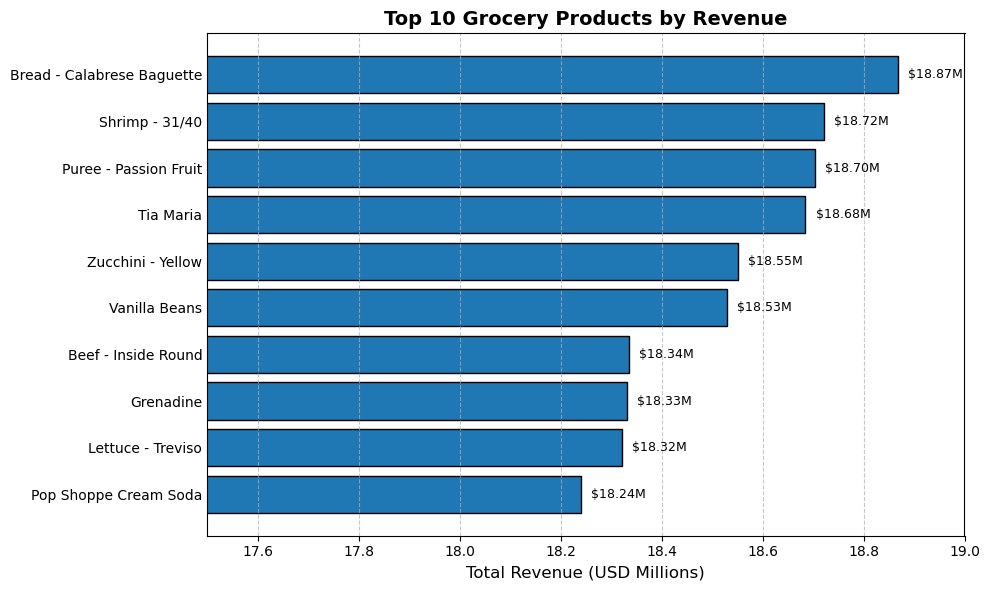

In [218]:
top_products_df_sorted = top_products_df.sort_values("TotalRevenue (Millions)", ascending=True)

plt.figure(figsize=(10, 6))

product_bars = plt.barh(
    top_products_df_sorted["ProductName"],
    top_products_df_sorted["TotalRevenue (Millions)"],
    edgecolor='black'
)

for bar in product_bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"${width:.2f}M", va='center', fontsize=9)

plt.xlim([17.5, 19])
plt.tick_params(axis='y', length=0)
plt.title("Top 10 Grocery Products by Revenue", fontsize=14, weight='bold')
plt.xlabel("Total Revenue (USD Millions)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save this for use as a hero visual
plt.savefig("top_products_hero.png", dpi=300)

plt.show()

We can see that the top-performing product is "Bread - Calabrese Baguette" which generated USD 18.87 million in total revenue. This is followed by "Shrimp - 31/40" at USD 18.72 million and "Puree - Passion Fruit" at USD 18.70 million. Before we move on, I'm curious to see if there are duplicate or similar products that could be grouped together. There are over 450 different products in the "products" table, and accurately grouping each of them might take time and require more institutional knowledge from within this grocery chain. But as an example, let's look and see if there are multiple products that contain the capitalized word, "Bread."

In [220]:
all_products_query = """
SELECT p.ProductID, p.ProductName, 
       c.CategoryName, 
       ROUND(SUM((s.Quantity * p.Price * (1 - s.Discount)) / 1000000), 3) AS 'TotalRevenue (Millions)'
  FROM products AS p 
  JOIN categories AS c 
    ON p.CategoryID = c.CategoryID 
  JOIN sales AS s 
    ON p.ProductID = s.ProductID 
 GROUP BY p.ProductID 
 ORDER BY `TotalRevenue (Millions)` DESC;
 """

all_products_df = pd.read_sql_query(all_products_query, conn)
bread_products_df = all_products_df[all_products_df["ProductName"].str.contains(r"Bread")]
print(bread_products_df.sort_values("ProductName", ascending=True))

     ProductID                      ProductName CategoryName  \
169        391             Bread - Bistro White  Confections   
0          345       Bread - Calabrese Baguette        Dairy   
301        235           Bread - English Muffin      Seafood   
415        107          Bread - French Baquette  Confections   
199        229             Bread - Hot Dog Buns      Poultry   
172        367   Bread - Italian Corn Meal Poly    Beverages   
200        287  Bread - Italian Roll With Herbs         Meat   
14         217               Bread - Multigrain        Grain   
84          42       Bread - Raisin Walnut Oval  Confections   
40         341    Bread - Roll, Canadian Dinner  Confections   
112        189   Bread - Roll, Soft White Round    Beverages   
65         337                      Bread - Rye      Cereals   
451        165    Bread Crumbs - Japanese Style      Seafood   
79         221             Bread Crumbs - Panko      Cereals   
447        283             Bread Fig And

In [221]:
print(f"Number of products containing the capitalized word 'Bread': {bread_products_df.shape[0]}")
print(f"Combined revenue: USD {bread_products_df["TotalRevenue (Millions)"].sum()} million")    

Number of products containing the capitalized word 'Bread': 16
Combined revenue: USD 186.29 million


As we can see, there are 16 products that have the capitalized word "Bread" in their name. All of these products together have more than USD 186 million in revenue, which is about 10 times as much as the highest single product ("Bread - Calabrese Baguette"). This suggests it might be worth grouping similar products together to see how well they perform. 

Note, a couple of the products are actually "Bread Crumbs," so they might belong in a group on their own. We also notice that some of the given Category Names seem to be potentially incorrect. For example, "Bread - English Muffin" is under "Seafood" and "Bread - Italian Corn Meal Poly" is under "Beverages." This might be an error of a few lines or products might be systematically miscategorized. 

To take this analysis deeper, we might want to consult with someone on the product team to decide which products should be grouped together and which categories may not be correct. But we'll leave it there for this project.

## Product Categories

In [224]:
top_categories_query = """
WITH category_sales AS (
    SELECT c.CategoryID, c.CategoryName,
           ROUND(SUM((s.Quantity * p.Price * (1 - s.Discount)) / 1000000), 3) AS 'TotalRevenue_Millions'
      FROM sales s
      JOIN products p ON s.ProductID = p.ProductID
      JOIN categories c ON p.CategoryID = c.CategoryID
     GROUP BY c.CategoryName
     ),
     ranked_categories AS (
    SELECT *,
           RANK() OVER (ORDER BY TotalRevenue_Millions DESC) AS 'RevenueRank'
      FROM category_sales
      )

SELECT * 
  FROM ranked_categories;
"""

top_categories_df = pd.read_sql_query(top_categories_query, conn)
print(top_categories_df)

    CategoryID CategoryName  TotalRevenue_Millions  RevenueRank
0            1  Confections                556.931            1
1            7         Meat                492.889            2
2            9      Poultry                440.026            3
3            3      Cereals                427.393            4
4           10       Snails                372.085            5
5           11      Produce                368.244            6
6            5    Beverages                366.515            7
7            4        Dairy                354.358            8
8            6      Seafood                330.528            9
9            8        Grain                323.879           10
10           2   Shell fish                299.598           11


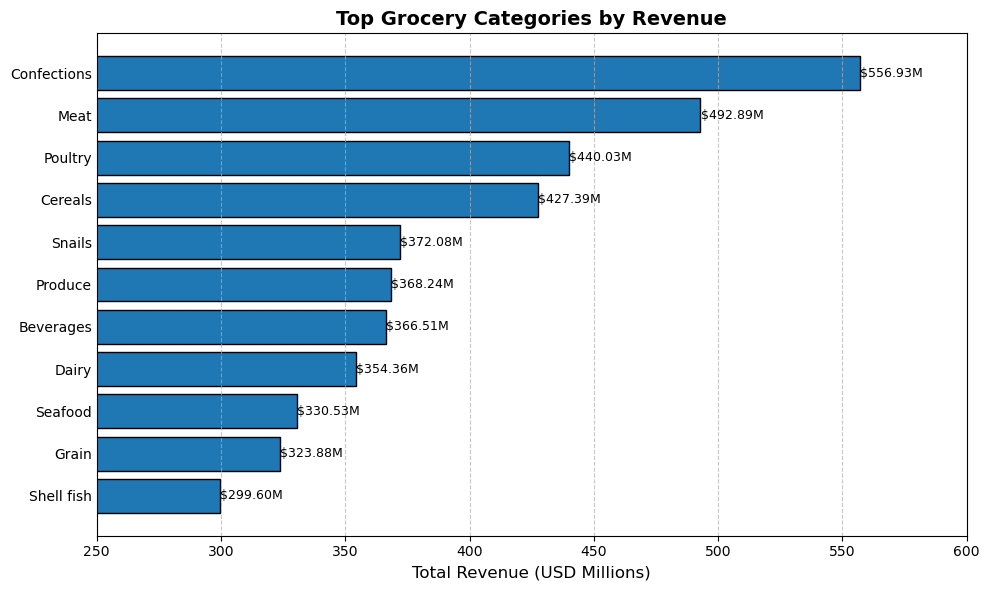

In [225]:
top_categories_df_sorted = top_categories_df.sort_values("TotalRevenue_Millions", ascending=True)

plt.figure(figsize=(10, 6))

category_bars = plt.barh(
    top_categories_df_sorted["CategoryName"],
    top_categories_df_sorted["TotalRevenue_Millions"],
    edgecolor='black'
)

for bar in category_bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"${width:.2f}M", va='center', fontsize=9)

plt.xlim([250, 600])
plt.tick_params(axis='y', length=0)
plt.title("Top Grocery Categories by Revenue", fontsize=14, weight='bold')
plt.xlabel("Total Revenue (USD Millions)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

With the caveat we noted above that some products' Category Names might be incorrect, we can see for now that "Confections" is the top-performing category, totaling almost USD 557 million in revenue. Next comes "Meat" at USD 492 million. "Poultry" and "Cereals" come in 3rd and 4th.

# 2. Customers
Next, I'll look at high-value customers. I'll aggregate the sales data by customer by pulling in columns from a few different tables, look at the distribution of total spend, and pull out a small number of customers who spend the most.

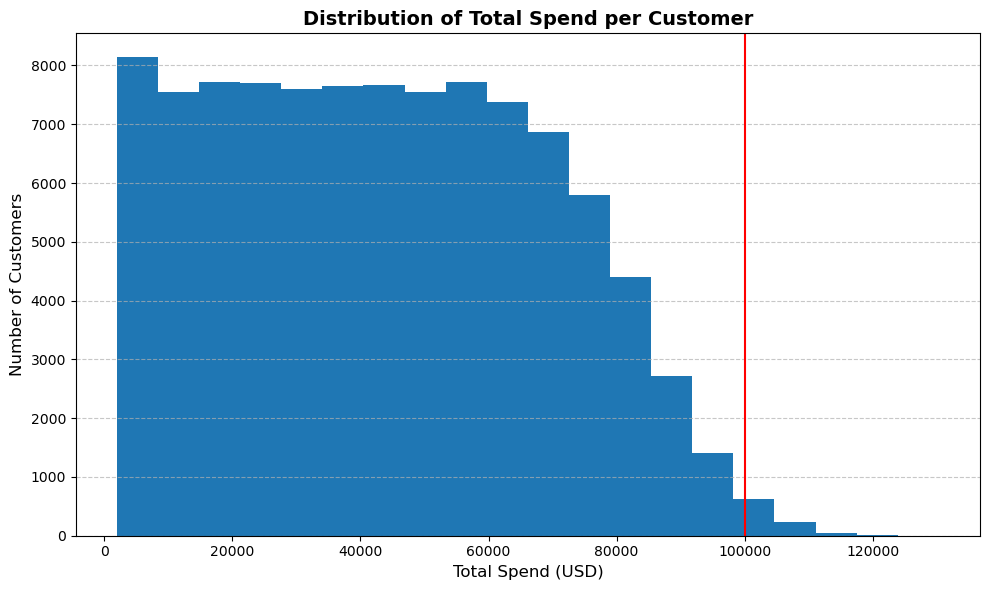

In [228]:
customers_query = """
SELECT c.CustomerID, c.FirstName, c.LastName, 
       ROUND(SUM(s.Quantity * p.Price * (1 - s.Discount)), 2) AS 'TotalSpend (USD)' 
  FROM products AS p 
  JOIN sales AS s 
    ON p.ProductID = s.ProductID 
  JOIN customers AS c 
    ON s.CustomerID = c.CustomerID 
 GROUP BY c.CustomerID 
 ORDER BY `TotalSpend (USD)` DESC;
 """

customers_df = pd.read_sql_query(customers_query, conn)

plt.figure(figsize=(10, 6))

plt.hist(customers_df["TotalSpend (USD)"], bins=20)
plt.xlabel("Total Spend (USD)", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.title("Distribution of Total Spend per Customer", fontsize=14, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Set a threshold of USD 100,000 for high-value customers
plt.axvline(100000, color="red")

In the histogram above, we can see that the distribution of total spend per customer is right-skewed. The distribution is rather uniform between USD 0 and USD 60,000 and then tapers off, with progressively smaller numbers of customers spending between USD 60,000 and USD 100,000. A very small number of customers have spent more than USD 100,000.

Based on the specific needs of the company, we could come up with criteria to identify high-value customers. This could be based on percentiles, proportion of total revenue accounted for, etc. For this example, we'll say high-value customers are those spending USD 100,000 or more. Below, I'll filter the list to include just those customers. 

In [230]:
high_value_customers_df = customers_df[customers_df["TotalSpend (USD)"] >= 100000]
print(high_value_customers_df)

     CustomerID FirstName  LastName  TotalSpend (USD)
0         94800     Wayne      Chan         130324.16
1         95972    Olivia      Dean         123004.86
2         97863     Ronda   Wallace         121922.59
3         95048    Ericka  O'Connor         121883.95
4         95157     Paula       Lin         120849.78
..          ...       ...       ...               ...
686       96567    Yvette    Waters         100044.60
687       96933      Ross  Humphrey         100025.79
688       96687     Dante     Stout         100021.52
689       87601     Micah   Burgess         100016.68
690       93980     Erica     Weiss         100001.74

[691 rows x 4 columns]


In [231]:
print(f"Total customers: {customers_df.shape[0]}. High-value customers: {high_value_customers_df.shape[0]}.")

Total customers: 98759. High-value customers: 691.


Before wrapping up this section, it is worth assessing how sensitive our definition of "high-value" customers is. For example, if we change the definition of "high-value" by +/- USD 5,000, do we get a significantly smaller/larger number of customers? The company may want to be able to change its "high-value" classification more flexibly depending on what it plans to do with the information (e.g., offer discounts, incentives, etc.). To assess this sensitivity, we'll define a flexible function to show how many customers are above a certain spend threshold.

In [233]:
def customers_spend_above(threshold):
    result = len(customers_df["CustomerID"][customers_df["TotalSpend (USD)"] >= threshold])
    return result

print(f"There are {customers_spend_above(95000)} customers with total spend above USD 95,000")
print(f"There are {customers_spend_above(105000)} customers with total spend above USD 105,000")

There are 1498 customers with total spend above USD 95,000
There are 289 customers with total spend above USD 105,000


We can see that the number of "high-value" customers is pretty sensitive to the threshold we use. If we lower it to USD 95,000, we get almost 1,500 customers. Meanwhile, if we raise it to USD 105,000, we get under 300 customers. Therefore, when setting the threshold for "high-value" customers, the company will need to be mindful of how many customers it wants to target with any initiatives and the potential costs/benefits of those initiatives. Once they settle on what threshold to use and how many customers are included, the company could engage them by offering rewards, enrolling them in a loyalty program, or come up with other ideas aimed at retaining their business.

# 3. Employees
Finally, I'll look at sales numbers for each employee and identify the top-performing employees in terms of sales volume. 

In [236]:
top_employees_query = """
WITH employee_sales AS (
    SELECT s.SalesPersonID, 
           e.FirstName, e.LastName, 
           COUNT(*) AS 'NumSales', 
           ROUND(SUM((s.Quantity * p.Price * (1 - s.Discount)) / 1000000), 3) AS 'TotalSales_Millions'
      FROM products AS p 
      JOIN sales AS s 
        ON p.ProductID = s.ProductID 
      JOIN employees AS e 
        ON s.SalesPersonID = e.EmployeeID 
     GROUP BY s.SalesPersonID
     ),
     ranked_employees AS (
    SELECT *,
           RANK() OVER (ORDER BY TotalSales_Millions DESC) AS 'SalesRank'
      FROM employee_sales
      )

SELECT * 
  FROM ranked_employees;
"""

top_employees_df = pd.read_sql_query(top_employees_query, conn)
print(top_employees_df)

    SalesPersonID  FirstName   LastName  NumSales  TotalSales_Millions  \
0              21      Devon     Brewer    294983              190.043   
1              20     Shelby     Riddle    293562              189.413   
2              13     Katina      Marks    293530              189.313   
3               5    Desiree     Stuart    293711              189.223   
4               4    Darnell    Nielsen    294744              189.136   
5              14      Wendi    Buckley    294035              189.062   
6               8      Julie       Dyer    294449              188.863   
7               7   Chadwick       Cook    293967              188.795   
8               6      Holly    Collins    293973              188.785   
9              22      Tonia  Mc Millan    293224              188.781   
10             12    Lindsay       Chen    293164              188.631   
11             19    Bernard      Moody    293875              188.458   
12             18     Warren   Bartlet

There are 23 employees in the database. Based on the table above, there is not much variation in sales performance. This might be a feature of how the database was simulated. Nonetheless, we can identify Devon Brewer as the top-performing salesperson with just over USD 190 million in sales. With this information, the company could implement some sort of employee rewards program or identify realistic sales goals for future time periods.

In [238]:
conn.close()

# Conclusion
In this example project, I looked at simulated sales data for a grocery store chain and analyzed products, customers, and employees. I downloaded the data files from Kaggle and read them into SQLite. I used SQL queries to compile and aggregate the relevant data for each question, and then used Python commands to filter the data and visualize the results. Depending on the company's needs, they could use the insights from this project to decide on what products to develop further, which customers to engage more meaningfully, and how to reward employees for their performance.